<a href="https://colab.research.google.com/github/filsto/GAN/blob/main/DCGANtensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Réseau antagoniste génératif à convolution profonde**

Deep Convolutional Generative Adversarial Network

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [3]:
# to generate GIF
$ pip install imageio
$ pip install git+https://github.com/tensorflow/docs

SyntaxError: ignored

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

charger et préparer le jeu de données MNIST

In [6]:
(train_images, train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 #normalize the images to [-1,1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Créer les modèles


In [10]:
# Le générateur

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7,7,256) #note= None is the batch size

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape == (None, 7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape == (None, 14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28,28,1)

  return model


Le générateur utilise tf.keras.layers.Conv2DTranspose (suréchantillonnage) pour produire une image à partir d'une graine (bruit aléatoire). Commencez avec un calque Dense qui prend cette graine en entrée, puis suréchantillonnez plusieurs fois jusqu'à ce que vous atteigniez la taille d'image souhaitée de 28x28x1. Notez l'activation de tf.keras.layers.LeakyReLU pour chaque couche, à l'exception de la couche de sortie qui utilise tanh.

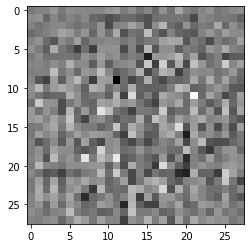

In [11]:
# utilisons le générateur (pas encore formé) pour créer une image

generator = make_generator_model()

noise= tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [15]:
# Le discriminateur

# classificateur d'images basé sur CNN

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00164546]], shape=(1, 1), dtype=float32)


In [17]:
# Définir la perte et les optimiseurs

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# perte du discriminateur
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [19]:
#perte du générateur
def generator_loss(fake_output):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
# Enregistrer les points de contrôle
#Ce bloc-notes montre également comment enregistrer et restaurer des modèles, ce qui peut être utile en cas d'interruption d'une longue tâche d'entraînement.

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [22]:
# définir la boucle d'entraînement

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
#notice the use of tf.function that causes the function to be compiled

@tf.function

def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)

    # produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs +1, seed)

   #save the model every 15 epochs
    if (epoch+1) %15 ==0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
  
  # generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [25]:
# générer et enregistrer des images

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

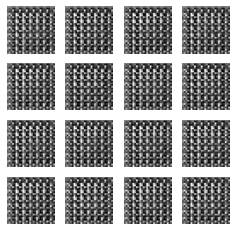

Time for epoch 1 is 674.6915059089661 sec


In [ ]:
# former le modèle
train(train_dataset, EPOCHS)


In [ ]:
# restaurer le dernier point de contrôle
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#créer un GIF

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
# utiliser imageio pour creer un GIF animé à partir des images enregistrées lors de la formation

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)